# Natural Language Processing with Disaster Tweets
https://github.com/aparnnaH/Natural-Language-Processing-with-Disaster-Tweets
## Overview:
This project is about teaching a computer to figure out if a tweet is talking about a real disaster or not. People often tweet during emergencies, but not every tweet is actually about something serious happening. So, the challenge is to build a model that can tell the difference. The dataset we’re working with has about 10,000 tweets, and each one is tagged as either a real disaster tweet or just a regular tweet. Each tweet is just a piece of text, and they come in all shapes and sizes. The model has to pick up on clues in the words to decide if the tweet is genuinely about a disaster or not.

In [1]:
# Load and Preview the Data
import pandas as pd
train = pd.read_csv("train.csv")
train[['text', 'target']].head()

,text,target
0,Our Deeds are the Reason of this #earthquake M...,1
1,Forest fire near La Ronge Sask. Canada,1
2,All residents asked to 'shelter in place' are ...,1
3,"13,000 people receive #wildfires evacuation or...",1
4,Just got sent this photo from Ruby #Alaska as ...,1


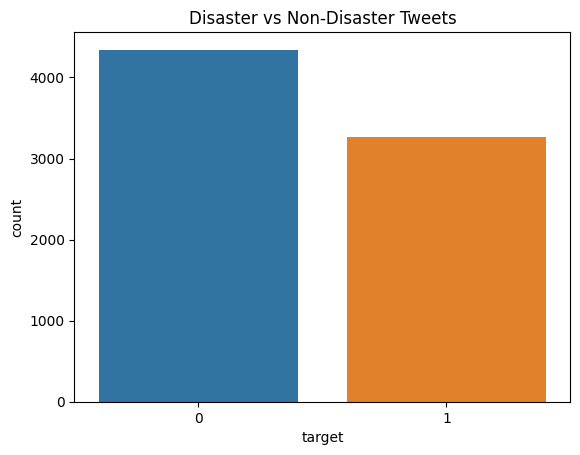

In [2]:
# Basic Exploratory Data Analysis (EDA)

import matplotlib.pyplot as plt
import seaborn as sns

# how many tweets are about real disasters (1) vs not (0)
sns.countplot(x='target', data=train)
plt.title("Disaster vs Non-Disaster Tweets")
plt.show()

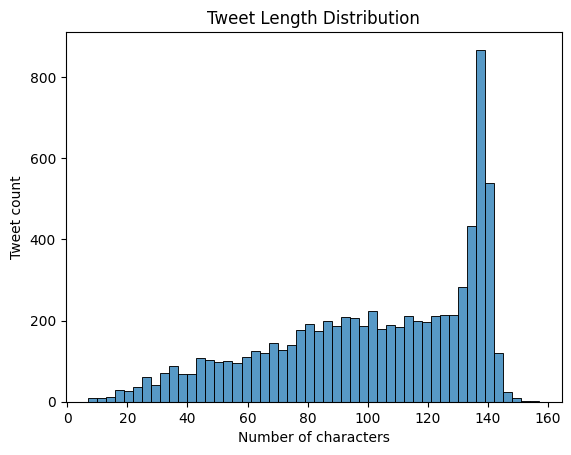

In [3]:
# Look at the distribution of tweet lengths
# See how much text we’re dealing with on average

train['text_length'] = train['text'].apply(len)
sns.histplot(train['text_length'], bins=50)
plt.title("Tweet Length Distribution")
plt.xlabel("Number of characters")
plt.ylabel("Tweet count")
plt.show()

In [4]:
import re
import nltk
from nltk.corpus import stopwords

nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

# text cleaning function
def clean_text(text):
    text = re.sub(r"http\S+", "", text)  # remove URLs
    text = re.sub(r"[^a-zA-Z ]", "", text)  # remove special characters and numbers
    words = text.lower().split()  # convert to lowercase and split
    return " ".join([w for w in words if w not in stop_words])  # remove stopwords

# Apply cleaning to the dataset
train['clean_text'] = train['text'].apply(clean_text)

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/aparnnahariharan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [5]:
# Check clean text
train['clean_text']

0            deeds reason earthquake may allah forgive us
1                   forest fire near la ronge sask canada
2       residents asked shelter place notified officer...
3       people receive wildfires evacuation orders cal...
4       got sent photo ruby alaska smoke wildfires pou...
                              ...                        
7608    two giant cranes holding bridge collapse nearb...
7609    ariaahrary thetawniest control wild fires cali...
7610                                 utckm volcano hawaii
7611    police investigating ebike collided car little...
7612    latest homes razed northern california wildfir...
Name: clean_text, Length: 7613, dtype: object

In [6]:
# Convert Text to Features Using TF-IDF
from sklearn.feature_extraction.text import TfidfVectorizer

# Convert the cleaned text into numerical features using TF-IDF
# how important a word is in a tweet relative to the rest of the tweets
vectorizer = TfidfVectorizer(max_features=10000, ngram_range=(1,2))
X = vectorizer.fit_transform(train['clean_text'])
y = train['target']


In [7]:
# Deep Learning Model with LSTM
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Tokenize the text
tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(train['clean_text'])
sequences = tokenizer.texts_to_sequences(train['clean_text'])
X_seq = pad_sequences(sequences, maxlen=100)

# Split into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_seq, y, test_size=0.2, random_state=42)

2025-06-18 11:13:41.903245: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [14]:
# Define a LSTM-based model

deep_model = Sequential()
deep_model.add(Embedding(input_dim=10000, output_dim=64, input_length=100))  # word embeddings
deep_model.add(LSTM(64))
deep_model.add(Dropout(0.3))  # prevent overfitting
deep_model.add(Dense(1, activation='sigmoid'))  # for binary classification

# Compile and train the model
deep_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
history = deep_model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=5, batch_size=32)

Epoch 1/5
191/191 [==============================] - 8s 32ms/step - loss: 0.5498 - accuracy: 0.7120 - val_loss: 0.4482 - val_accuracy: 0.7978
Epoch 2/5
191/191 [==============================] - 6s 32ms/step - loss: 0.3244 - accuracy: 0.8706 - val_loss: 0.4761 - val_accuracy: 0.7912
Epoch 3/5
191/191 [==============================] - 6s 32ms/step - loss: 0.2206 - accuracy: 0.9156 - val_loss: 0.5576 - val_accuracy: 0.7715
Epoch 4/5
191/191 [==============================] - 6s 29ms/step - loss: 0.1592 - accuracy: 0.9420 - val_loss: 0.6332 - val_accuracy: 0.7663
Epoch 5/5
191/191 [==============================] - 6s 30ms/step - loss: 0.1206 - accuracy: 0.9578 - val_loss: 0.7811 - val_accuracy: 0.7485


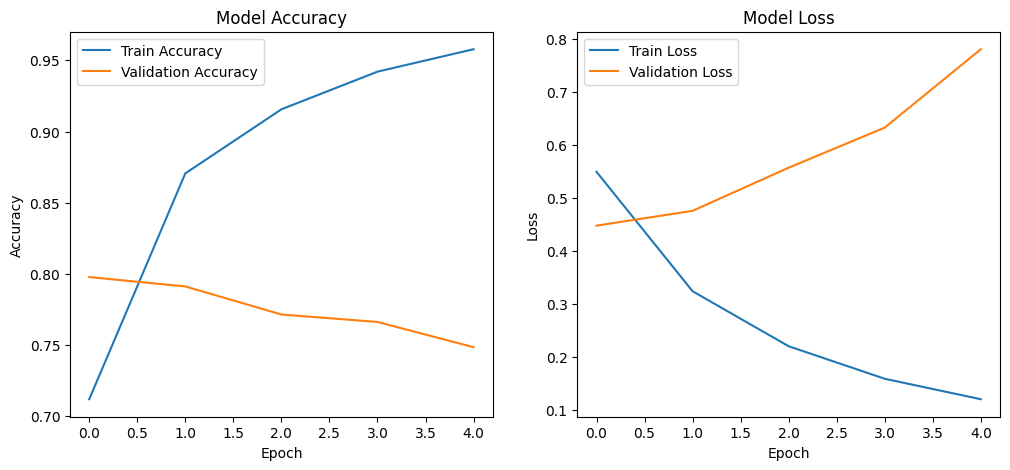

In [15]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(12,5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [10]:
from sklearn.metrics import f1_score

# Make predictions on validation set
preds = deep_model.predict(X_val)
preds_label = (preds > 0.5).astype(int)  # convert probabilities to binary labels

# Calculate F1 Score to evaluate performance
print("F1 Score:", f1_score(y_val, preds_label))

48/48 [==============================] - 0s 10ms/step
F1 Score: 0.7038167938931298


## Conclusion 
The LSTM model did a pretty good job picking up on patterns in the tweets about disasters. It learned quickly and performed well on the training data, but the drop in validation accuracy and rising validation loss suggest it started to overfit after a few rounds. The F1 score around 0.7 means it’s decent at telling real disaster tweets apart from the rest, but there’s definitely room for improvement.

If I were to keep working on this, I’d try adding things like early stopping to prevent overfitting, experimenting with more complex models like bidirectional LSTMs or transformers, or even using pre-trained embeddings to give the model a boost. Overall, this project was a useful introduction to the tricky task of figuring out which tweets actually describe real emergencies.

In [13]:
test = pd.read_csv("test.csv")
test['clean_text'] = test['text'].apply(clean_text)

# Tokenize and pad the test text
test_sequences = tokenizer.texts_to_sequences(test['clean_text'])
X_test_seq = pad_sequences(test_sequences, maxlen=100)

test_preds = deep_model.predict(X_test_seq)
test_preds_label = (test_preds > 0.5).astype(int).flatten()

submission = pd.DataFrame({
    'id': test['id'],
    'target': test_preds_label.astype(int)
})

# Save to CSV
submission.to_csv("submission.csv", index=False)

102/102 [==============================] - 1s 9ms/step
